# Validation Analysis Notebook

This notebook analyzes rubric data generated by the `analyze_rubric_authors.py` script.

## Instructions
1. Make sure you have a CSV file generated from `analyze_rubric_authors.py` (e.g., `rubric_data_[insert_author_name].csv`)
2. Update the `csv_file_path` variable below to point to your CSV file
3. Run all cells to generate the analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [11]:
# UPDATE THIS PATH TO YOUR CSV FILE
csv_file_path = "rubric_data_yimdriuska.m.csv"

# Load the data
try:
    df = pd.read_csv(csv_file_path)
    print(f"Successfully loaded {len(df)} rows from {csv_file_path}")
    print(f"Data shape: {df.shape}")
    print(f"Author: {df['Author_Email'].iloc[0] if len(df) > 0 else 'Unknown'}")
except FileNotFoundError:
    print(f"File not found: {csv_file_path}")
    print("Please update the csv_file_path variable with the correct path to your CSV file.")
    raise
except Exception as e:
    print(f"Error loading CSV: {e}")
    raise

Successfully loaded 18 rows from rubric_data_yimdriuska.m.csv
Data shape: (18, 20)
Author: yimdriuska.m@gmail.com


In [12]:
# Quick data preview
print("Column names:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")

print(f"\nFirst few rows:")
df.head(3)

Column names:
 1. Rubric_ID
 2. Author_Email
 3. Case_ID
 4. Case_Name
 5. Rubric_Created_Date
 6. Rubric_Updated_Date
 7. Validation_Status
 8. Rubric_Criteria_Details
 9. Case_Classification
10. Rubric_Comments
11. Rubric_LLM_Vendor
12. Rubric_LLM_Model
13. Rubric_Temperature
14. Score_ID
15. Generated_Note_ID
16. Overall_Score
17. Score_Created_Date
18. Score_Updated_Date
19. Scoring_Details
20. Score_LLM_Vendor

First few rows:


,Rubric_ID,Author_Email,Case_ID,Case_Name,Rubric_Created_Date,Rubric_Updated_Date,Validation_Status,Rubric_Criteria_Details,Case_Classification,Rubric_Comments,Rubric_LLM_Vendor,Rubric_LLM_Model,Rubric_Temperature,Score_ID,Generated_Note_ID,Overall_Score,Score_Created_Date,Score_Updated_Date,Scoring_Details,Score_LLM_Vendor
0,103,yimdriuska.m@gmail.com,145,Patient_13,2025-08-19 03:19:18,2025-08-19 04:37:28,not_evaluated,[1] Reward for accurately documenting that the...,manual,Copied from rubric,manual,manual,0.0,587,418,38.0,2025-08-19 04:32:47,2025-08-19 04:32:47,"[1] List data: [0, 'Appeal follow-up task note...",OpenAI
1,103,yimdriuska.m@gmail.com,145,Patient_13,2025-08-19 03:19:18,2025-08-19 04:37:28,not_evaluated,[1] Reward for accurately documenting that the...,manual,Copied from rubric,manual,manual,0.0,589,418,28.5,2025-08-19 04:32:51,2025-08-19 04:32:51,"[1] List data: [1, 'Mentions calling insurance...",OpenAI
2,103,yimdriuska.m@gmail.com,145,Patient_13,2025-08-19 03:19:18,2025-08-19 04:37:28,not_evaluated,[1] Reward for accurately documenting that the...,manual,Copied from rubric,manual,manual,0.0,591,418,34.5,2025-08-19 04:33:03,2025-08-19 04:33:03,"[1] List data: [1, 'Note only mentions clinici...",OpenAI


# Part 1: Basic Rubric Analysis

Analysis of rubrics created by the author, including criteria counts and total possible scores.

In [13]:
def parse_rubric_criteria(criteria_text):
    """Parse rubric criteria text and extract criterion details."""
    if pd.isna(criteria_text) or criteria_text == "No criteria":
        return []
    
    criteria = []
    # Split by ' | ' to get individual criteria
    parts = criteria_text.split(' | ')
    
    for part in parts:
        # Extract weight and sense using regex
        weight_match = re.search(r'Weight: (\d+)', part)
        sense_match = re.search(r'Sense: (\w+)', part)
        
        # Extract criterion text (everything before the parentheses)
        criterion_match = re.match(r'\[\d+\]\s*(.+?)\s*\(Weight:', part)
        
        if weight_match and sense_match:
            criterion = {
                'text': criterion_match.group(1).strip() if criterion_match else part.strip(),
                'weight': int(weight_match.group(1)),
                'sense': sense_match.group(1)
            }
            criteria.append(criterion)
    
    return criteria

# Get unique rubrics (one row per rubric)
unique_rubrics = df.drop_duplicates(subset=['Rubric_ID']).copy()

print("PART 1: BASIC RUBRIC ANALYSIS")
print("=" * 50)

print(f"Total rubrics created: {len(unique_rubrics)}")
print(f"Date range: {unique_rubrics['Rubric_Created_Date'].min()} to {unique_rubrics['Rubric_Created_Date'].max()}")

# Analyze each rubric
rubric_analysis = []

for _, row in unique_rubrics.iterrows():
    rubric_id = row['Rubric_ID']
    criteria = parse_rubric_criteria(row['Rubric_Criteria_Details'])
    
    # Calculate total possible score
    positive_score = sum(c['weight'] for c in criteria if c['sense'] == 'positive')
    negative_penalty = sum(c['weight'] for c in criteria if c['sense'] == 'negative')
    total_possible = positive_score  # Maximum if all positive criteria met and no penalties
    worst_possible = positive_score - negative_penalty  # If all positive missed and all penalties applied
    
    analysis = {
        'rubric_id': rubric_id,
        'case_name': row['Case_Name'],
        'criteria_count': len(criteria),
        'positive_criteria': sum(1 for c in criteria if c['sense'] == 'positive'),
        'negative_criteria': sum(1 for c in criteria if c['sense'] == 'negative'),
        'total_positive_weight': positive_score,
        'total_negative_weight': negative_penalty,
        'max_possible_score': total_possible,
        'min_possible_score': worst_possible,
        'score_range': total_possible - worst_possible
    }
    
    rubric_analysis.append(analysis)

rubric_df = pd.DataFrame(rubric_analysis)
rubric_df

PART 1: BASIC RUBRIC ANALYSIS
Total rubrics created: 1
Date range: 2025-08-19 03:19:18 to 2025-08-19 03:19:18


,rubric_id,case_name,criteria_count,positive_criteria,negative_criteria,total_positive_weight,total_negative_weight,max_possible_score,min_possible_score,score_range
0,103,Patient_13,20,17,3,290,65,290,225,65


In [14]:
# Summary statistics for rubrics
print("RUBRIC SUMMARY STATISTICS")
print("=" * 30)
print(f"Average criteria per rubric: {rubric_df['criteria_count'].mean():.1f}")
print(f"Average positive criteria: {rubric_df['positive_criteria'].mean():.1f}")
print(f"Average negative criteria: {rubric_df['negative_criteria'].mean():.1f}")
print(f"Average max possible score: {rubric_df['max_possible_score'].mean():.1f}")
print(f"Average min possible score: {rubric_df['min_possible_score'].mean():.1f}")
print(f"Average score range: {rubric_df['score_range'].mean():.1f}")

# Detailed breakdown by rubric
print("\nDETAILED RUBRIC BREAKDOWN")
print("=" * 40)
for _, row in rubric_df.iterrows():
    print(f"\nRubric ID {row['rubric_id']} ({row['case_name']})")
    print(f" {row['criteria_count']} total criteria ({row['positive_criteria']} positive, {row['negative_criteria']} negative)")
    print(f"  Score range: {row['min_possible_score']:.1f} to {row['max_possible_score']:.1f} (range: {row['score_range']:.1f})")
    print(f"  Total positive weight: {row['total_positive_weight']}")
    print(f"  Total negative weight: {row['total_negative_weight']}")

RUBRIC SUMMARY STATISTICS
Average criteria per rubric: 20.0
Average positive criteria: 17.0
Average negative criteria: 3.0
Average max possible score: 290.0
Average min possible score: 225.0
Average score range: 65.0

DETAILED RUBRIC BREAKDOWN

Rubric ID 103 (Patient_13)
 20 total criteria (17 positive, 3 negative)
  Score range: 225.0 to 290.0 (range: 65.0)
  Total positive weight: 290
  Total negative weight: 65


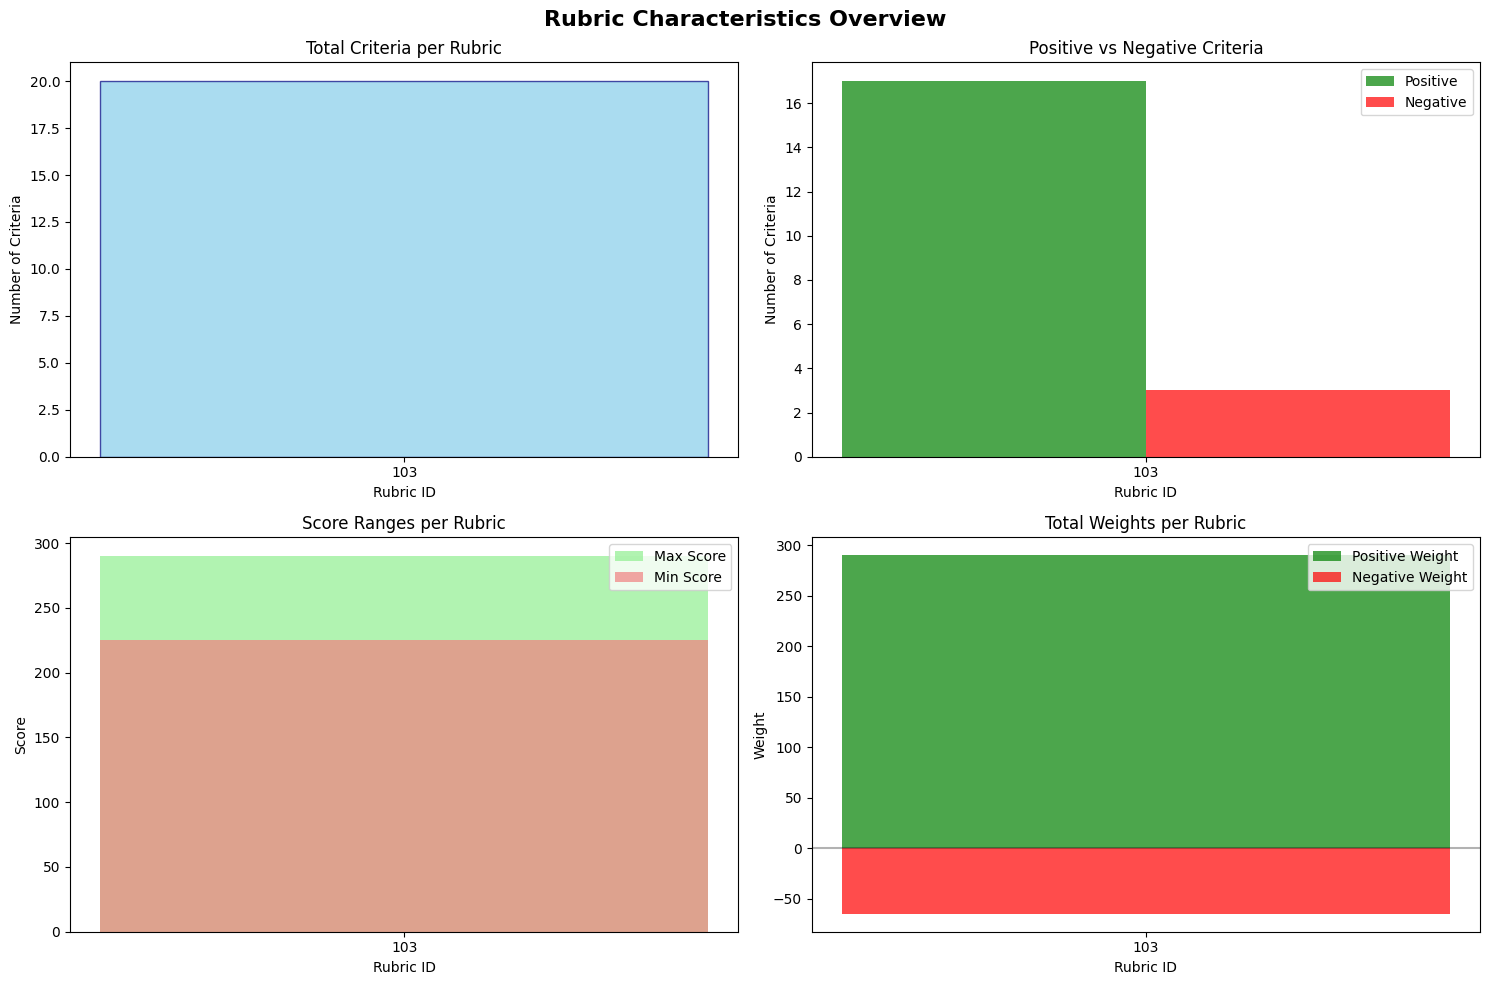

In [15]:
# Visualize rubric characteristics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Rubric Characteristics Overview', fontsize=16, fontweight='bold')

# Criteria count per rubric
axes[0,0].bar(rubric_df['rubric_id'].astype(str), rubric_df['criteria_count'], 
              color='skyblue', edgecolor='navy', alpha=0.7)
axes[0,0].set_title('Total Criteria per Rubric')
axes[0,0].set_xlabel('Rubric ID')
axes[0,0].set_ylabel('Number of Criteria')

# Positive vs negative criteria
width = 0.35
x = np.arange(len(rubric_df))
axes[0,1].bar(x - width/2, rubric_df['positive_criteria'], width, 
              label='Positive', color='green', alpha=0.7)
axes[0,1].bar(x + width/2, rubric_df['negative_criteria'], width, 
              label='Negative', color='red', alpha=0.7)
axes[0,1].set_title('Positive vs Negative Criteria')
axes[0,1].set_xlabel('Rubric ID')
axes[0,1].set_ylabel('Number of Criteria')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(rubric_df['rubric_id'].astype(str))
axes[0,1].legend()

# Score ranges
axes[1,0].bar(rubric_df['rubric_id'].astype(str), rubric_df['max_possible_score'], 
              color='lightgreen', alpha=0.7, label='Max Score')
axes[1,0].bar(rubric_df['rubric_id'].astype(str), rubric_df['min_possible_score'], 
              color='lightcoral', alpha=0.7, label='Min Score')
axes[1,0].set_title('Score Ranges per Rubric')
axes[1,0].set_xlabel('Rubric ID')
axes[1,0].set_ylabel('Score')
axes[1,0].legend()

# Weight distribution
axes[1,1].bar(rubric_df['rubric_id'].astype(str), rubric_df['total_positive_weight'], 
              color='green', alpha=0.7, label='Positive Weight')
axes[1,1].bar(rubric_df['rubric_id'].astype(str), -rubric_df['total_negative_weight'], 
              color='red', alpha=0.7, label='Negative Weight')
axes[1,1].set_title('Total Weights per Rubric')
axes[1,1].set_xlabel('Rubric ID')
axes[1,1].set_ylabel('Weight')
axes[1,1].legend()
axes[1,1].axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

# Part 2: Score Analysis

Analysis of how notes were scored using each rubric, including note counts and average scores.

In [16]:
print("PART 2: SCORE ANALYSIS")
print("=" * 30)

# Filter out rows where scoring data is available
scored_data = df[df['Generated_Note_ID'].notna() & df['Overall_Score'].notna()].copy()

print(f"Total scored notes: {len(scored_data)}")
print(f"Unique notes scored: {scored_data['Generated_Note_ID'].nunique()}")
print(f"Rubrics used for scoring: {scored_data['Rubric_ID'].nunique()}")

# Analyze scoring by rubric
scoring_analysis = []

for rubric_id in scored_data['Rubric_ID'].unique():
    rubric_scores = scored_data[scored_data['Rubric_ID'] == rubric_id]
    
    # Get rubric info
    rubric_info = rubric_df[rubric_df['rubric_id'] == rubric_id].iloc[0]
    
    analysis = {
        'rubric_id': rubric_id,
        'case_name': rubric_info['case_name'],
        'notes_graded': len(rubric_scores),
        'unique_notes': rubric_scores['Generated_Note_ID'].nunique(),
        'avg_score': rubric_scores['Overall_Score'].mean(),
        'median_score': rubric_scores['Overall_Score'].median(),
        'min_score': rubric_scores['Overall_Score'].min(),
        'max_score': rubric_scores['Overall_Score'].max(),
        'std_score': rubric_scores['Overall_Score'].std(),
        'max_possible': rubric_info['max_possible_score'],
        'min_possible': rubric_info['min_possible_score'],
        'score_range': rubric_info['score_range']
    }
    
    # Calculate performance metrics
    analysis['avg_score_pct'] = ((analysis['avg_score'] - analysis['min_possible']) / 
                                analysis['score_range'] * 100) if analysis['score_range'] > 0 else 0
    
    scoring_analysis.append(analysis)

scoring_df = pd.DataFrame(scoring_analysis)
scoring_df

PART 2: SCORE ANALYSIS
Total scored notes: 18
Unique notes scored: 2
Rubrics used for scoring: 1


,rubric_id,case_name,notes_graded,unique_notes,avg_score,median_score,min_score,max_score,std_score,max_possible,min_possible,score_range,avg_score_pct
0,103,Patient_13,18,2,39.222222,37.75,24.0,54.0,8.371823,290,225,65,-285.811966


SCORE DISTRIBUTION VISUALIZATION


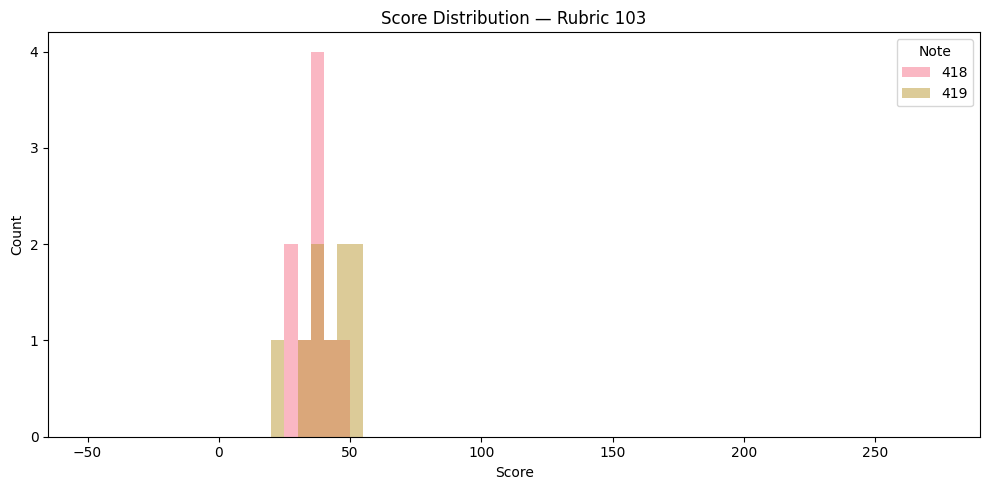

In [17]:
# Score Distribution by Rubric with Note Separation
print("SCORE DISTRIBUTION VISUALIZATION")
print("=" * 40)

from matplotlib.ticker import MaxNLocator

# Use existing `scored_data` if present; else load the uploaded CSV as a fallback
try:
    scored_data  # type: ignore[name-defined]
except NameError:
    scored_data = pd.read_csv("/mnt/data/rubric_data_ganganadella.csv")

# Guard: keep only rows with an overall score
scored_data = scored_data.copy()
if "Overall_Score" not in scored_data.columns:
    raise ValueError("`Overall_Score` column missing from scored_data.")

# --- Parse rubric min/max from criteria details text ---
_weight_sense_re = re.compile(
    r"\(Weight:\s*([\-]?\d+(?:\.\d+)?)\s*,\s*Sense:\s*(positive|negative)\)",
    re.IGNORECASE,
)

def rubric_min_max_from_text(text: str) -> tuple[float, float]:
    """Return (min_possible, max_possible) for a rubric details blob.
       Max = sum(positive weights); Min = -sum(negative weights)."""
    if not isinstance(text, str):
        return (np.nan, np.nan)
    matches = _weight_sense_re.findall(text)
    if not matches:
        return (np.nan, np.nan)
    pos_total = sum(float(w) for w, s in matches if s.lower().startswith("pos"))
    neg_total = sum(float(w) for w, s in matches if s.lower().startswith("neg"))
    return (-neg_total, pos_total)

# Build a per-Rubric_ID map of (min_possible, max_possible)
rubric_bounds: dict[int, tuple[float, float]] = {}
if "Rubric_Criteria_Details" in scored_data.columns:
    for rid, g in scored_data.groupby("Rubric_ID"):
        details = g["Rubric_Criteria_Details"].dropna()
        if len(details) == 0:
            rubric_bounds[rid] = (np.nan, np.nan)
        else:
            rubric_bounds[rid] = rubric_min_max_from_text(details.iloc[0])
else:
    # Fallback: observed range only (if criteria text unavailable)
    for rid, g in scored_data.groupby("Rubric_ID"):
        rubric_bounds[rid] = (float(g["Overall_Score"].min()), float(g["Overall_Score"].max()))

# Choose note label column
note_col = "Generated_Note_ID" if "Generated_Note_ID" in scored_data.columns else (
    "Case_Name" if "Case_Name" in scored_data.columns else None
)
if note_col is None:
    raise ValueError("Need a note identifier column: 'Generated_Note_ID' or 'Case_Name'.")

# Which rubrics have scores
scored_rubrics = scored_data.loc[scored_data["Overall_Score"].notna(), "Rubric_ID"].unique()

for rubric_id in scored_rubrics:
    df_r = scored_data[(scored_data["Rubric_ID"] == rubric_id) & scored_data["Overall_Score"].notna()]
    if df_r.empty:
        continue

    # Axis range from rubric definition; fall back to observed if needed
    min_possible, max_possible = rubric_bounds.get(rubric_id, (np.nan, np.nan))
    if np.isnan(min_possible) or np.isnan(max_possible) or (min_possible > max_possible):
        min_possible = float(df_r["Overall_Score"].min())
        max_possible = float(df_r["Overall_Score"].max())

    # Build bins that cover the entire possible range
    scores_arr = df_r["Overall_Score"].astype(float).to_numpy()
    bin_width = 5.0
    bins = np.arange(min_possible, max_possible + bin_width * 1.001, bin_width)

    plt.figure(figsize=(10, 5))
    for note_val, df_note in df_r.groupby(note_col):
        plt.hist(
            df_note["Overall_Score"].astype(float).to_numpy(),
            bins=bins,
            density=False,           # integer counts, not densities
            alpha=0.5,               # overlap readability
            label=str(note_val),
            histtype="stepfilled",
            linewidth=1.0,
        )

    plt.title(f"Score Distribution — Rubric {rubric_id}")
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.xlim(min_possible, max_possible)
    # Force integer ticks on the y-axis
    ax = plt.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(title="Note", loc="best", frameon=True)
    plt.tight_layout()
    plt.show()


In [18]:
# Detailed scoring breakdown
print("SCORING BREAKDOWN BY RUBRIC")
print("=" * 40)

for _, row in scoring_df.iterrows():
    print(f"\nRubric ID {row['rubric_id']} ({row['case_name']})")
    print(f" Notes graded: {row['notes_graded']} (unique: {row['unique_notes']})")
    print(f"  Score statistics:")
    print(f"  Average: {row['avg_score']:.2f}")
    print(f"  Median: {row['median_score']:.2f}")
    print(f"  Range: {row['min_score']:.2f} to {row['max_score']:.2f}")
    print(f"  Std Dev: {row['std_score']:.2f}")
    print(f"  Performance: {row['avg_score_pct']:.1f}% of possible range")
    print(f"  Possible range: {row['min_possible']:.1f} to {row['max_possible']:.1f}")
    
    # Show individual note scores for this rubric
    rubric_scores = scored_data[scored_data['Rubric_ID'] == row['rubric_id']]
    print(f"Individual scores:")
    for _, score_row in rubric_scores.iterrows():
        print(f"      • Note {score_row['Generated_Note_ID']}: {score_row['Overall_Score']:.2f}")

SCORING BREAKDOWN BY RUBRIC

Rubric ID 103 (Patient_13)
 Notes graded: 18 (unique: 2)
  Score statistics:
  Average: 39.22
  Median: 37.75
  Range: 24.00 to 54.00
  Std Dev: 8.37
  Performance: -285.8% of possible range
  Possible range: 225.0 to 290.0
Individual scores:
      • Note 418: 38.00
      • Note 418: 28.50
      • Note 418: 34.50
      • Note 418: 49.50
      • Note 418: 35.50
      • Note 418: 37.50
      • Note 418: 28.50
      • Note 418: 36.50
      • Note 418: 41.50
      • Note 419: 36.00
      • Note 419: 42.00
      • Note 419: 45.50
      • Note 419: 54.00
      • Note 419: 34.75
      • Note 419: 46.75
      • Note 419: 24.00
      • Note 419: 54.00
      • Note 419: 39.00


In [19]:
# Overall summary
print("\nOVERALL ANALYSIS SUMMARY")
print("=" * 50)

total_criteria = rubric_df['criteria_count'].sum()
total_notes = len(scored_data)
avg_score_all = scored_data['Overall_Score'].mean()
median_score_all = scored_data['Overall_Score'].median()

print(f"Author: {df['Author_Email'].iloc[0]}")
print(f"Total rubrics created: {len(unique_rubrics)}")
print(f"Total criteria across all rubrics: {total_criteria}")
print(f"Average criteria per rubric: {total_criteria / len(unique_rubrics):.1f}")
print(f"\nScoring Summary:")
print(f"• Total notes scored: {total_notes}")
print(f"• Overall average score: {avg_score_all:.2f}")
print(f"• Overall median score: {median_score_all:.2f}")
print(f"• Best performing rubric: {scoring_df.loc[scoring_df['avg_score_pct'].idxmax(), 'rubric_id']} ({scoring_df['avg_score_pct'].max():.1f}% performance)")
print(f"• Most used rubric: {scoring_df.loc[scoring_df['notes_graded'].idxmax(), 'rubric_id']} ({scoring_df['notes_graded'].max()} notes graded)")


OVERALL ANALYSIS SUMMARY
Author: yimdriuska.m@gmail.com
Total rubrics created: 1
Total criteria across all rubrics: 20
Average criteria per rubric: 20.0

Scoring Summary:
• Total notes scored: 18
• Overall average score: 39.22
• Overall median score: 37.75
• Best performing rubric: 103 (-285.8% performance)
• Most used rubric: 103 (18 notes graded)
